In [8]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn
import math

READ THE CLEANED DATA

-relative abundance 

-microbiome HD is concatenated

-merged with meta data - healthy vs disease


In [126]:
dataHD = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_microbiomeHD_versionA")
dataAmericans = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_Americans_versionA", low_memory=False)

In [127]:
dataHD.drop(columns='Unnamed: 0', inplace=True)
dataAmericans.drop(columns='Unnamed: 0', inplace=True)

In [128]:
keep_features = [i for i in dataHD.columns if i in dataAmericans.columns]
n = len(keep_features)
print("features left: ", n)

features left:  139


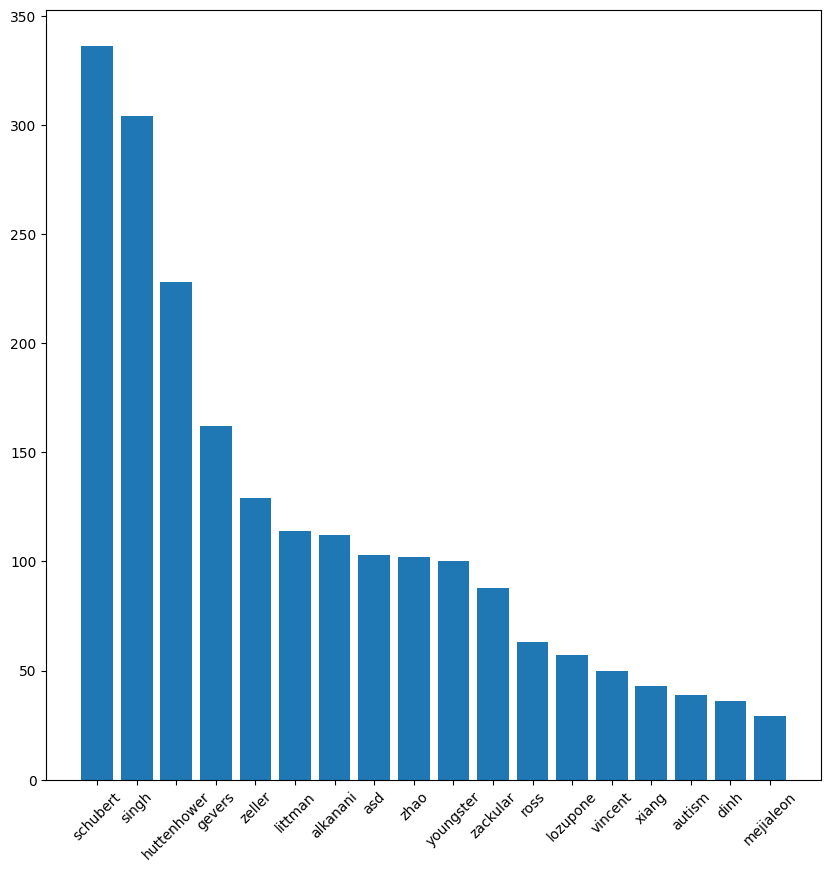

In [129]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(np.arange(0, len(dataHD.From.value_counts())), dataHD.From.value_counts())
plt.xticks(np.arange(0, len(dataHD.From.value_counts())), list(dataHD.From.value_counts().keys()), rotation=45)
plt.show()
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/samples_number.png')


In [130]:
dataHD_filtered = dataHD.loc[:,keep_features]
dataAmericans_filtered = dataAmericans.loc[:,keep_features]
print(dataAmericans_filtered.shape, dataHD_filtered.shape)


(9509, 139) (2095, 139)


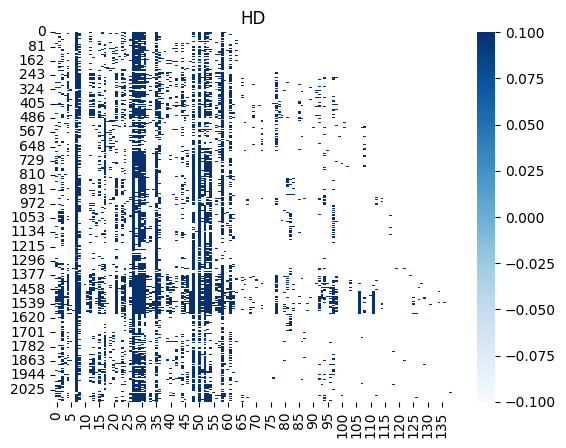

In [137]:
%matplotlib inline
np.seterr(divide = 'ignore')
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
plt.figure()
plt.xticks(range(n), keep_features)
plt.yticks(range(len(dataHD_filtered)))
plt.title('HD')
plot = seaborn.heatmap(-np.log(dataHD_filtered.values), cmap="Blues")
# plt.show()
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/HD_headtmap.png')


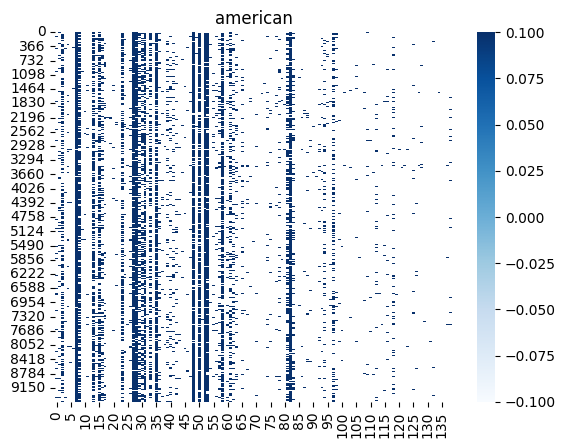

In [134]:
plt.figure()
plt.xticks(range(n), keep_features, rotation=90)
plt.yticks(range(len(dataAmericans_filtered)))
plt.title('american')
plot = seaborn.heatmap(-np.log(dataAmericans_filtered.values), cmap="Blues")
plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Americans_headtmap.png')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

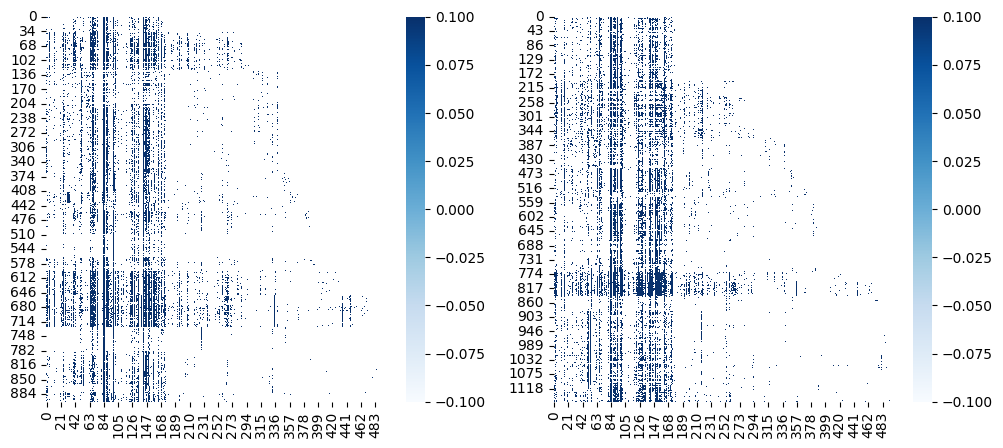

In [138]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
Healthy = dataHD.query("DiseaseState == 'H'").drop(columns=["DiseaseState", "From"])
Disease = dataHD.query("DiseaseState == 'D'").drop(columns=["DiseaseState", "From"])
seaborn.heatmap(-np.log(Healthy.values), cmap="Blues", ax=axes[0])
seaborn.heatmap(-np.log(Disease.values), cmap="Blues", ax=axes[1])
np.seterr(divide = 'warn')

After dropping features- whats left...

<BarContainer object of 2095 artists>

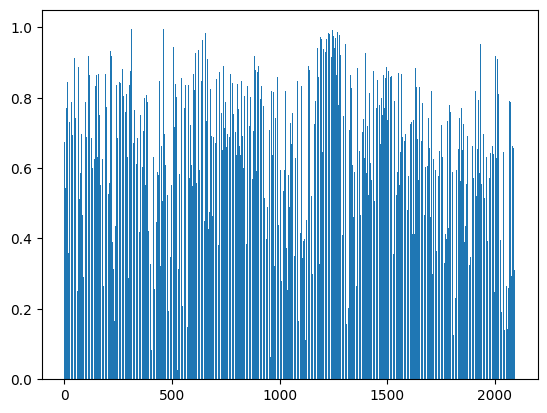

In [14]:
plt.bar(np.arange(0, len(dataHD_filtered)), list(dataHD_filtered.sum(axis=1)))
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Remaining_percentage_after_filter.png')

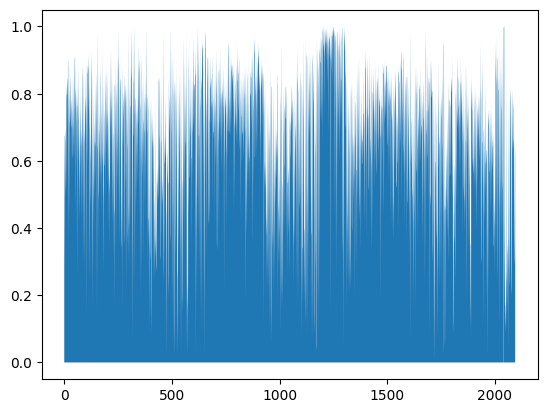

In [15]:
from scipy.interpolate import make_interp_spline, BSpline

#create data
x = np.arange(0, len(dataHD_filtered))
y = np.array(list(dataHD_filtered.sum(axis=1)))

plt.fill_between(x, y,0, alpha=1)
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Remaining_percentage_after_filter2.png')


In [16]:
all_data = pd.concat([dataAmericans_filtered, dataHD_filtered])

PCA- fit both data

In [115]:
pca = PCA(n_components=2)
pca.fit(dataAmericans_filtered)
components_americans1 = pca.transform(dataAmericans_filtered)
components_HD1 = pca.transform(dataHD_filtered)
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_americans1 = pd.DataFrame(data= components_americans1, columns= ['Pc1', 'Pc2'])
pca_HD1 = pd.DataFrame(data= components_HD1, columns= ['Pc1', 'Pc2'])


explained variance:  0.5327412907315143


PCA- fit only american

In [116]:
pca = PCA(n_components=2)
pca.fit(all_data)
components_americans2 = pca.transform(dataAmericans_filtered)
components_HD2 = pca.transform(dataHD_filtered)
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_americans2 = pd.DataFrame(data= components_americans2, columns= ['Pc1', 'Pc2'])
pca_HD2 = pd.DataFrame(data= components_HD2, columns= ['Pc1', 'Pc2'])

explained variance:  0.5890665615090996


PCA- all data vs only american's

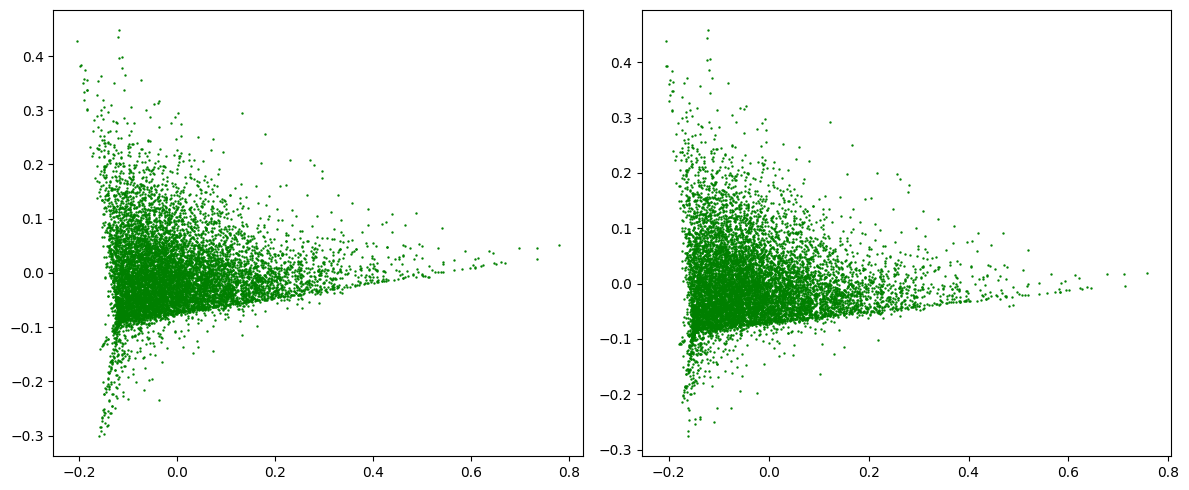

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
axes[1].scatter(pca_americans2.loc[:,'Pc1'], pca_americans2.loc[:,'Pc2'],marker='.',s=2, color= 'g')
fig.tight_layout()
plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/americans_pca_vs_all_pca.png')
plt.show()

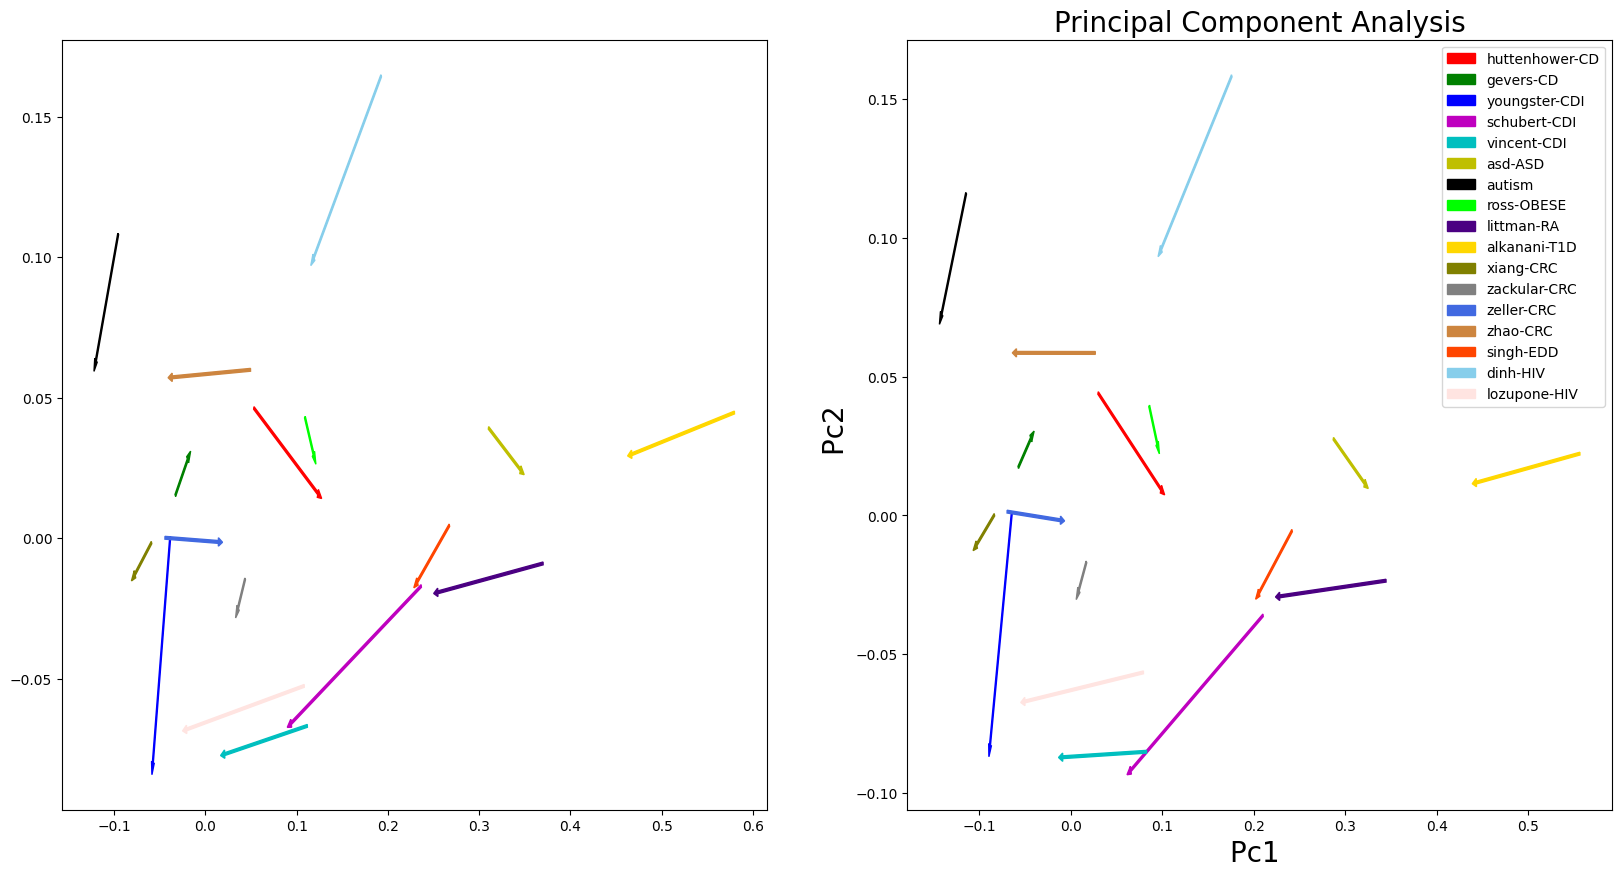

In [119]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
itr = [pca_HD1, pca_HD2]
polar_data = dict()
for i, pca_HD in enumerate(itr):
    plt.xlabel('Pc1 ', fontsize=20)
    plt.ylabel('Pc2 ', fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)

    targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
    colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
    arrows, var_x, var_y, angles, sizes = [], [], [], [], []
    # axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
    for target, color in zip(targets,colors):
        indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
        fill = 'none'
        if target[1] == "D":
            fill = color
        x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
        x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
        y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
        var_x.append(x_v)
        var_y.append(y_v)
        arrows.append(x)
        arrows.append(y)
        # axes[i].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
    # find centroids and plotting an arrow
    col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
    for j in range(0,len(arrows),4):
        axes[i].arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
        angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
        sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
    L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
    plt.legend(L) 
    polar_data[i] = [var_x, var_y, angles, sizes]
# fig.show()

In [22]:
disease = ["CD","CDI","autism", "Obese", "RA","T1D","CRC","EDD","HIV"]
disease_map = {"CD":["huttenhower", "gevers", "N", "N"],"CDI":["youngster", "schubert","vincent", "N"],"autism":['asd', 'autism', "N", "N"], "Obese":['ross', "N", "N", "N"], "RA":['littman', "N", "N", 'N'],"T1D":['alkanani', "N", "N", 'N'],"CRC":["xiang","zackular","zeller","zhao"],"EDD":['singh', "N", "N", "N"],"HIV":['dinh',"lozupone", "N", "N"]}


In [68]:
def pca_disease(disease):
    arrows = []
    data_partial = dataHD[(dataHD['From'] == disease_map[disease][0]) | (dataHD['From'] == disease_map[disease][1]) | (dataHD['From'] == disease_map[disease][2]) | (dataHD['From'] == disease_map[disease][3])]
    keep_features = [i for i in data_partial.columns if i in dataAmericans.columns and data_partial[i].sum() > 0.1] 
    print(len(keep_features))  
    data_filtered = data_partial.loc[:,keep_features]
    dataAmericans_filtered = dataAmericans.loc[:,keep_features]     
    pca = PCA(n_components=2)
    pca.fit(pd.concat([dataAmericans_filtered, data_filtered]))
    components_americans = pca.transform(dataAmericans_filtered)
    components_disease = pca.transform(data_filtered)
    print("explained variance: ", sum(pca.explained_variance_ratio_))
    pca_americans = pd.DataFrame(data= components_americans, columns= ['Pc1', 'Pc2'])
    pca_disease = pd.DataFrame(data= components_disease, columns= ['Pc1', 'Pc2'])  
    
    plt.xlabel('Pc1 ', fontsize=10)
    plt.ylabel('Pc2 ', fontsize=10)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = disease_map[disease]
    colors = ['r','c', 'b','lime']
    # plt.scatter(pca_americans.loc[:,'Pc1'], pca_americans.loc[:,'Pc2'],marker='.',s=2, color= 'g')
    for target, color in zip(targets,colors):
        indicesToKeep = (data_partial['From'] == target) & (data_partial['DiseaseState'] == 'H')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        # plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c=color, edgecolors=color, s=50)
        indicesToKeep = (data_partial['From'] == target) & (data_partial['DiseaseState'] == 'D')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        # plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c='none', edgecolors=color, s=50)
    
    # find centroids and plotting an arrow
    col = ['r', 'c', 'b', 'lime']
    for j in range(0,len(arrows),4):
        plt.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
    plt.legend(targets) 
    # fig.show() 

                              

40
explained variance:  0.6489307294356942


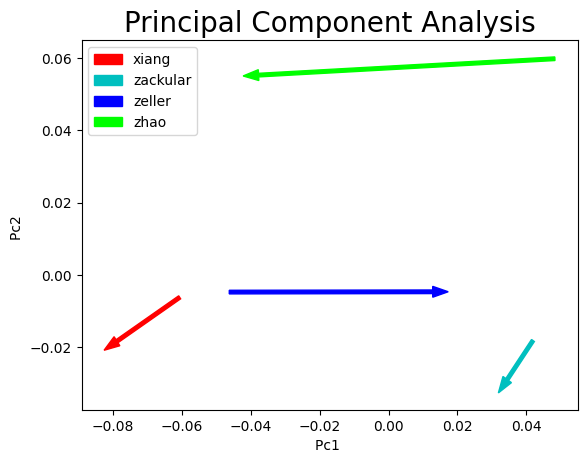

In [120]:
pca_disease("CRC")

POLAR PLOT

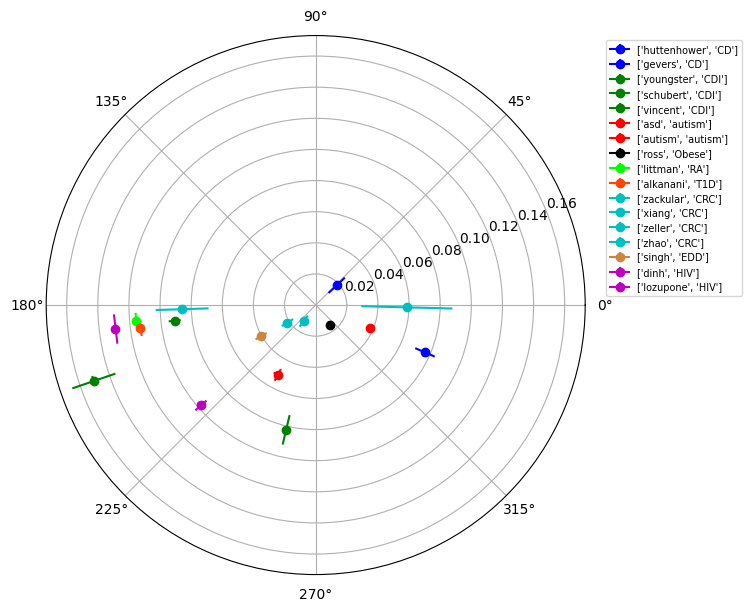

In [150]:
from matplotlib.patches import Ellipse
colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]
var_x, var_y, angles, sizes = polar_data[0]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    ax.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    # c = ax.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax.scatter(angle, size, c=color, alpha=0.75, s=50)
plt.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

Now only for the microbiomeHD PCA.

explained variance:  0.4777615573765877


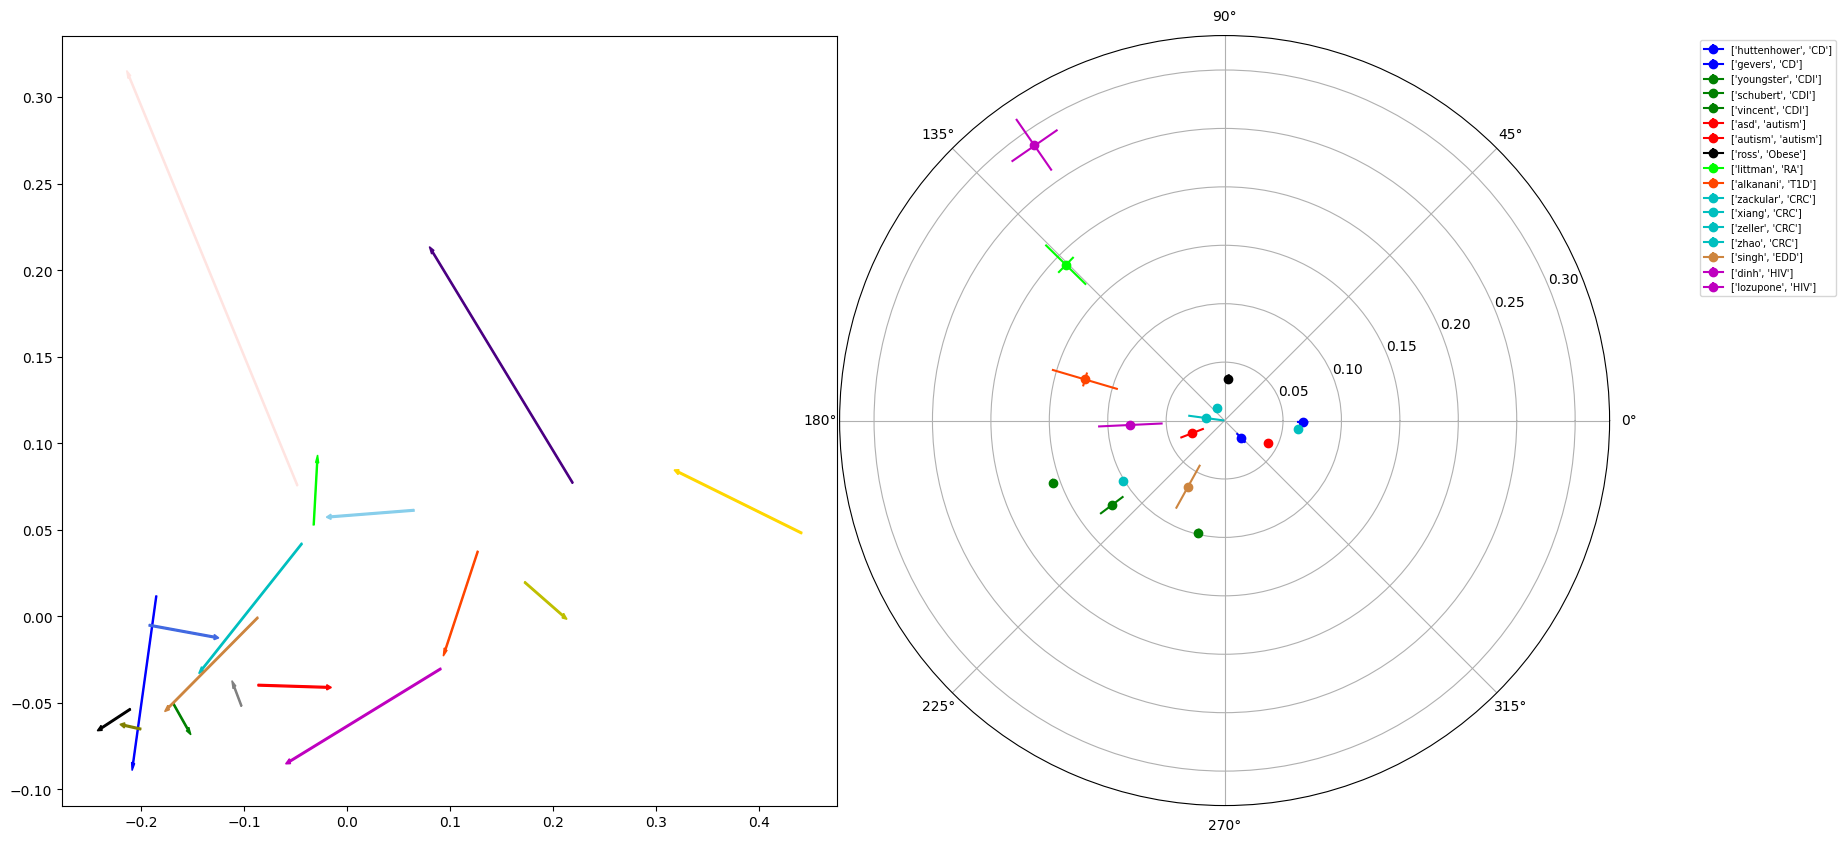

In [166]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)
# plt.xlabel('Pc1 ', fontsize=20)
# plt.ylabel('Pc2 ', fontsize=20)
# plt.title("Principal Component Analysis",fontsize=20)
targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
    fill = 'none'
    if target[1] == "D":
        fill = color
    x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    # axes[0].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    # c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

STATISTICS

In [ ]:
dataAmericans

In [ ]:
#american clean
start = "C:/Users/talno/microbiom_project/american_gut/"
data_americans = pd.read_csv(start + "feature_table_gtdb.tsv", sep='\t')
data_americans.drop('ID',inplace=True, axis=1)
data_americans["taxon1"] = data_americans['taxon'].str.split(';', expand=True)[5]
data_americans["taxon2"] = data_americans['taxon'].str.split(';', expand=True)[4]
data_americans = data_americans.groupby(['taxon2', 'taxon1']).sum()
data_americans = data_americans/data_americans.sum(axis=0)
data_americans.fillna(0,inplace=True)
data_americans = data_americans.T

In [ ]:
ibd_huttenhower = pd.read_csv("C:/Users/talno/microbiom_project/ibd_huttenhower_results/RDP/ibd_huttenhower.otu_table.100.denovo.rdp_assigned",sep='\t')
meta_huttenhower = pd.read_csv("C:/Users/talno/microbiom_project/ibd_huttenhower_results/ibd_huttenhower.metadata.txt",sep='\t')
# arrange the otu with disease state and where from and take just what appears in the meta data
def clean(meta,ibd,name):
    
    otu = ibd.copy()
    otu["taxon_g"] = otu["Unnamed: 0"].str.split(';', expand=True)[5]
    otu["taxon_f"] = otu["Unnamed: 0"].str.split(';', expand=True)[4]
    otu = otu.groupby(["taxon_f", "taxon_g"]).sum()
    try:
        otu.drop(('f__', 'g__'), inplace=True)
    except Exception:
        print("no g__, f__")
    otu = otu /otu.sum(axis = 0)
    otu.fillna(0,inplace=True)
    otu = otu.T
    meta.set_index("#SampleID", inplace=True)
    keepsmpls = [i for i in otu.index if i in meta.index]
    otu = otu.loc[keepsmpls]
    meta = meta.loc[keepsmpls]
    otu = otu.join(meta.DiseaseState)
    otu.loc[:, "DiseaseState"] = otu.loc[:, "DiseaseState"].map(
        {"ASD": "D", "nonCDI": "H", "nonIBD": "H", "CD": "D", "UC": "D", "CDI": "D", "H": "H", "postFMT_CDI": "H",
         "ASD": "D", 'HIV': "D", 'EDD': "D", "CRC": 'D', 'OB': "D", 'PAR': "D", "OW": "D", "CIRR": "D", "MHE": "D",
         "nonCRC": "H", "RA": "D", "T1D": "D", "CRC": "D"})
    otu["From"] = name
    # print(otu.shape, name,otu[otu["DiseaseState"] == "H"].shape,otu[otu["DiseaseState"] == "D"].shape)
    return otu

otu = clean(meta_huttenhower, ibd_huttenhower, "hutt")

In [ ]:
otu.sum(axis=1)

In [ ]:
data_americans.columns = data_americans.columns.get_level_values(1)

In [ ]:
data_americans

In [ ]:
data = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/clean_concat_microbiomeHD")

In [ ]:
data.set_index("Unnamed: 0", inplace=True)

In [ ]:
data.columns